In [1]:
%matplotlib inline

In [2]:
from __future__ import division
import numpy as np
# use fftw if available
try:
    from pyfftw.interfaces.numpy_fft import ifft2
except ImportError:
    from numpy.fft import ifft2

In [3]:
class GRF(object):

    grf_pixscale = 0.5 # 5
    grf_size = 0.2 # 4
    size_x = 1000
    size_y = 1000
    kolmogorov_n = 3.67
    rms = 0.05
    pixscale = 0.27

    def __init__(self):

        if self.kolmogorov_n == 2:
            raise Exception("beta is not defined if kolmogorov-n = 2")

        delta = self.grf_pixscale / 3600. / 180. * np.pi
        omega = 2. * np.pi / delta
        n_points = int(self.grf_size / delta / 180. * np.pi)
        if n_points % 2 == 0:  # make sure the number of points is even
            n_points -= 1

        beta = np.abs(2. - self.kolmogorov_n) * (self.grf_size / 180. * np.pi)**(2. - self.kolmogorov_n) \
               * self.rms**2 / (2. * np.pi)**(1. - self.kolmogorov_n) / (.5 * n_points)**(2. - self.kolmogorov_n) \
               - 2**(2. - self.kolmogorov_n)

        cnm = np.empty((n_points,  n_points), dtype=np.complex128)
        kmin = 4 * np.pi / (self.grf_size / 180. * np.pi)

        for i in range(n_points):
            for j in range(n_points // 2 + 1):
                # linear interpolation
                k_ij = np.sqrt((omega * (i / n_points - (0 if i < n_points / 2 else 1)))**2
                               + (omega * (j / n_points - (0 if j < n_points / 2 else 1)))**2)
                p_ij = beta * k_ij**-self.kolmogorov_n if k_ij >= kmin else 0
                scale = np.sqrt(p_ij / (2 * n_points * n_points)) / delta
                # create re/im
                if scale == 0:
                    cnm[i, j] = 0
                elif i == 0 or j == 0 or i == n_points // 2 or j == n_points // 2:
                    cnm[i, j] = np.random.normal(0, 2 * scale)
                else:
                    cnm[i, j] = np.random.normal(0, scale) + \
                                1j * np.random.normal(0, scale)
        for i in range(n_points):
            for j in range(n_points // 2 + 1, n_points):
                cnm[i, j] = cnm[n_points - i - 1, n_points - j].conjugate()
        self.exy = ifft2(cnm)

    def __call__(self, x, y):
        # TODO: move coordinates to the center of the random field
        grf_x = ((x - self.size_x / 2) * self.pixscale + self.grf_size * 1800.) / self.grf_pixscale
        grf_y = ((y - self.size_y / 2) * self.pixscale + self.grf_size * 1800.) / self.grf_pixscale
        
        grf_x_int = np.floor(grf_x).astype(np.int_)
        grf_y_int = np.floor(grf_y).astype(np.int_)

        p0 = (grf_x - np.floor(grf_x)) * self.exy[grf_x_int, grf_y_int].real + \
             (np.floor(grf_x) + 1 - grf_x) * self.exy[grf_x_int + 1, grf_y_int].real
        p1 = (grf_x - np.floor(grf_x)) * self.exy[grf_x_int, grf_y_int + 1].real + \
             (np.floor(grf_x) + 1 - grf_x) * self.exy[grf_x_int + 1, grf_y_int + 1].real
        return (grf_y - np.floor(grf_y)) * p0 + (np.floor(grf_y) + 1 - grf_y) * p1

In [6]:
grf_e1, grf_e2 = GRF(), GRF()

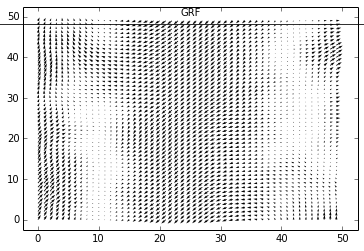

In [7]:
from pylab import *

X, Y = np.meshgrid(np.arange(0, GRF.size_x, 20), np.arange(0, GRF.size_x, 20))
E1, E2 = grf_e1(X, Y), grf_e2(X, Y)

clf()
Q = quiver(E1, E2)
quiverkey(Q, 0.5, 0.92, 2, 'GRF')
l,r,b,t = axis()
dx, dy = r-l, t-b
axis([l-0.05*dx, r+0.05*dx, b-0.05*dy, t+0.05*dy])
show()